In [1]:
################################################## Terms to consider ################################################################
# * Prepping dataset for regression
#
#
#
#
#
#
#
#
#
#
#
#
#
#######################################################################################################################################

In [2]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [3]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

In [5]:
weekly.shape

(32400, 39)

In [7]:
# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

In [9]:
weekly1.isna().sum()

player_id                      0
player_name                    0
position                       0
recent_team                    0
season                         0
week                           0
carries                        0
rushing_yards                  0
rushing_tds                    0
rushing_fumbles                0
rushing_fumbles_lost           0
rushing_first_downs            0
rushing_epa                    0
receptions                     0
targets                        0
receiving_yards                0
receiving_tds                  0
receiving_fumbles              0
receiving_fumbles_lost         0
receiving_air_yards            0
receiving_yards_after_catch    0
receiving_first_downs          0
receiving_epa                  0
racr                           0
target_share                   0
air_yards_share                0
wopr                           0
offense_snaps                  0
offense_pct                    0
redzone                        0
total_usag

In [10]:
weekly1.head()

,player_id,player_name,position,recent_team,season,week,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,fantasy_points_ppr
14,00-0021547,A.Gates,TE,LAC,2016,1,0,0.0,0,0.0,0.0,0.0,0.0,3,4,20.0,0,0.0,0.0,19.0,9.0,0.0,-0.258469,1.052632,0.111111,0.087156,0.227676,48.0,0.66,0.0,4,2.0,5.0
15,00-0021547,A.Gates,TE,LAC,2016,2,0,0.0,0,0.0,0.0,0.0,0.0,3,5,15.0,1,0.0,0.0,25.0,8.0,2.0,0.662646,0.600000,0.200000,0.122549,0.385784,36.0,0.53,3.0,5,7.5,10.5
16,00-0021547,A.Gates,TE,LAC,2016,5,0,0.0,0,0.0,0.0,0.0,0.0,4,5,30.0,1,1.0,1.0,36.0,6.0,2.0,-0.809390,0.833333,0.166667,0.076596,0.303617,18.0,0.35,1.0,5,7.0,11.0
17,00-0021547,A.Gates,TE,LAC,2016,6,0,0.0,0,0.0,0.0,0.0,0.0,2,6,16.0,0,0.0,0.0,52.0,4.0,2.0,-0.385813,0.307692,0.206897,0.256158,0.489655,31.0,0.47,0.0,6,1.6,3.6
18,00-0021547,A.Gates,TE,LAC,2016,7,0,0.0,0,0.0,0.0,0.0,0.0,5,10,38.0,0,0.0,0.0,77.0,13.0,3.0,1.970081,0.493507,0.227273,0.198454,0.479827,38.0,0.51,3.0,10,3.8,8.8


In [26]:
weekly1["scored"] = np.where((weekly1["receiving_tds"] > 0) | (weekly1["rushing_tds"] > 0), 1, 0)
weekly1["multi_score"] = np.where(weekly1["receiving_tds"] + weekly1["rushing_tds"] > 1, 1, 0)
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]
weekly1["total_epa"] = weekly1["rushing_epa"] + weekly1["receiving_epa"]
weekly1["total_first_downs"] = weekly1["rushing_first_downs"] + weekly1["receiving_first_downs"]


try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]


model_data = weekly1[try_columns]
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
14,-0.258469,0.0,0.111111,0.0,0.66,4
15,0.662646,2.0,0.200000,3.0,0.53,5
16,-0.809390,2.0,0.166667,1.0,0.35,5
17,-0.385813,2.0,0.206897,0.0,0.47,6
18,1.970081,3.0,0.227273,3.0,0.51,10


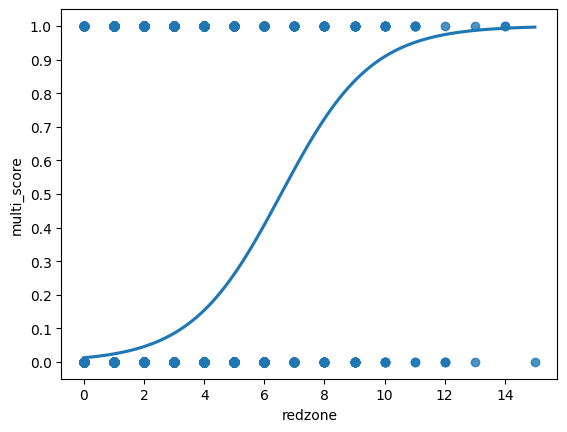

In [24]:
sns.regplot(x=weekly1["redzone"], y=weekly1["multi_score"], logistic=True, ci=None)
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.show()

# 9 redzone attempts results in a .90 probability

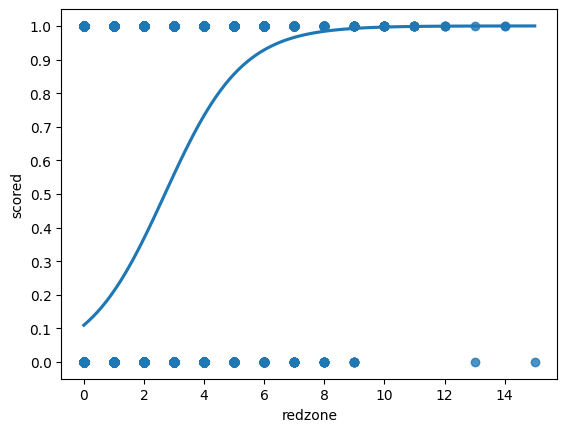

In [21]:
sns.regplot(x=weekly1["redzone"], y=weekly1["scored"], logistic=True, ci=None)
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.show()

# !! When redzone attempts is at least 5, there is a nearly .90 probability of a TD

In [25]:
# We can potentially identify sleeper/overrated players by checking their redzone attempts vs touchdowns scored
# Expected fantasy points vs actual

In [34]:
weekly1_rb = weekly1[weekly["position"] == "RB"]
model_data_rb = weekly1_rb[try_columns]

weekly1_non_rb = weekly1[~(weekly["position"] == "RB")]
model_data_non_rb = weekly1_non_rb[try_columns]

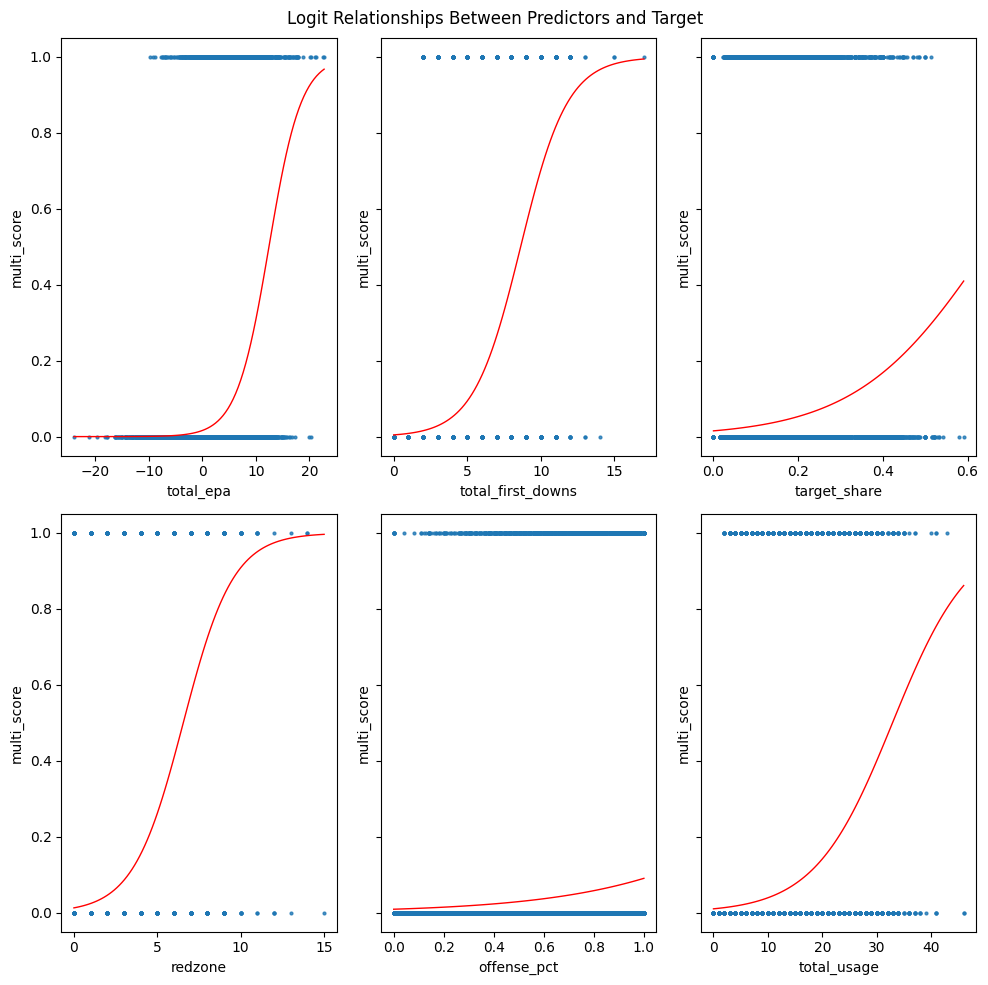

In [31]:
# With try columns

# y = weekly1[["scored"]]
y = weekly1[["multi_score"]]

ncols = int(np.ceil(np.sqrt(len(try_columns))))
nrows = int(np.ceil(len(try_columns) / ncols))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharey=True)
fig.suptitle("Logit Relationships Between Predictors and Target")

# Flatten the axes if nrows > 1
ax = ax.flatten()

for i, (col, ax_) in enumerate(zip(model_data.columns, ax)):
    scatter_style = dict(s=4)
    line_style = dict(color="red", linestyle="-", linewidth=1)

    sns.regplot(x=model_data[col], y=y, ax=ax_, logistic=True, ci=None, scatter_kws=scatter_style, line_kws=line_style)
    # ax_.set_title(col)

# Remove extra subplots
for i in range(len(model_data.columns), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

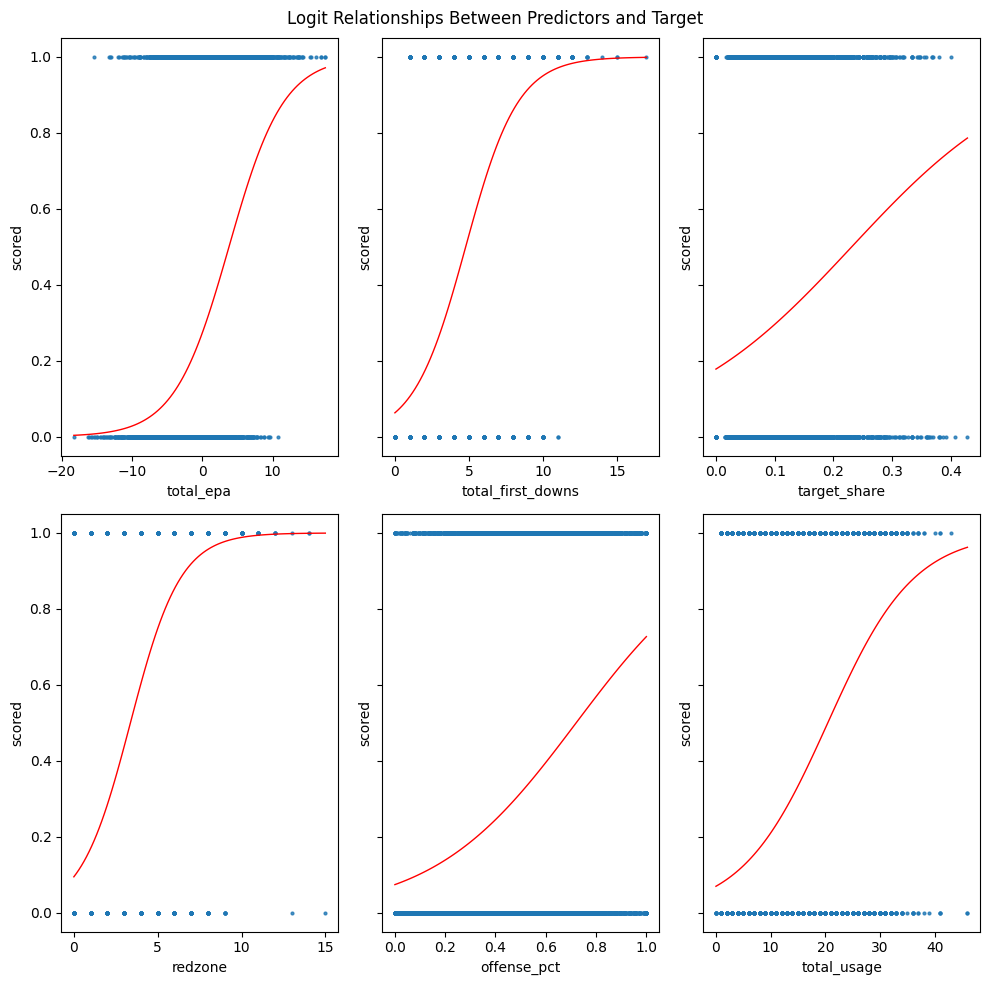

In [37]:
# With try columns, RBs ONLY!!!!!

y = weekly1_rb[["scored"]]
# y = weekly1_rb[["multi_score"]]

ncols = int(np.ceil(np.sqrt(len(try_columns))))
nrows = int(np.ceil(len(try_columns) / ncols))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharey=True)
fig.suptitle("Logit Relationships Between Predictors and Target (RBs)")

# Flatten the axes if nrows > 1
ax = ax.flatten()

for i, (col, ax_) in enumerate(zip(model_data_rb.columns, ax)):
    scatter_style = dict(s=4)
    line_style = dict(color="red", linestyle="-", linewidth=1)

    sns.regplot(x=model_data_rb[col], y=y, ax=ax_, logistic=True, ci=None, scatter_kws=scatter_style, line_kws=line_style)
    # ax_.set_title(col)

# Remove extra subplots
for i in range(len(model_data_rb.columns), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

In [ ]:
# Offense percent and usage does not seem to really be massive indicators of scoring unless total usage is 30 or more
# We may need to move Deandre Swift and Javonte Williams...
# Is EPA too correlated with scoring? Scoring a TD obviously increases expected points added. It's worth looking at this more...

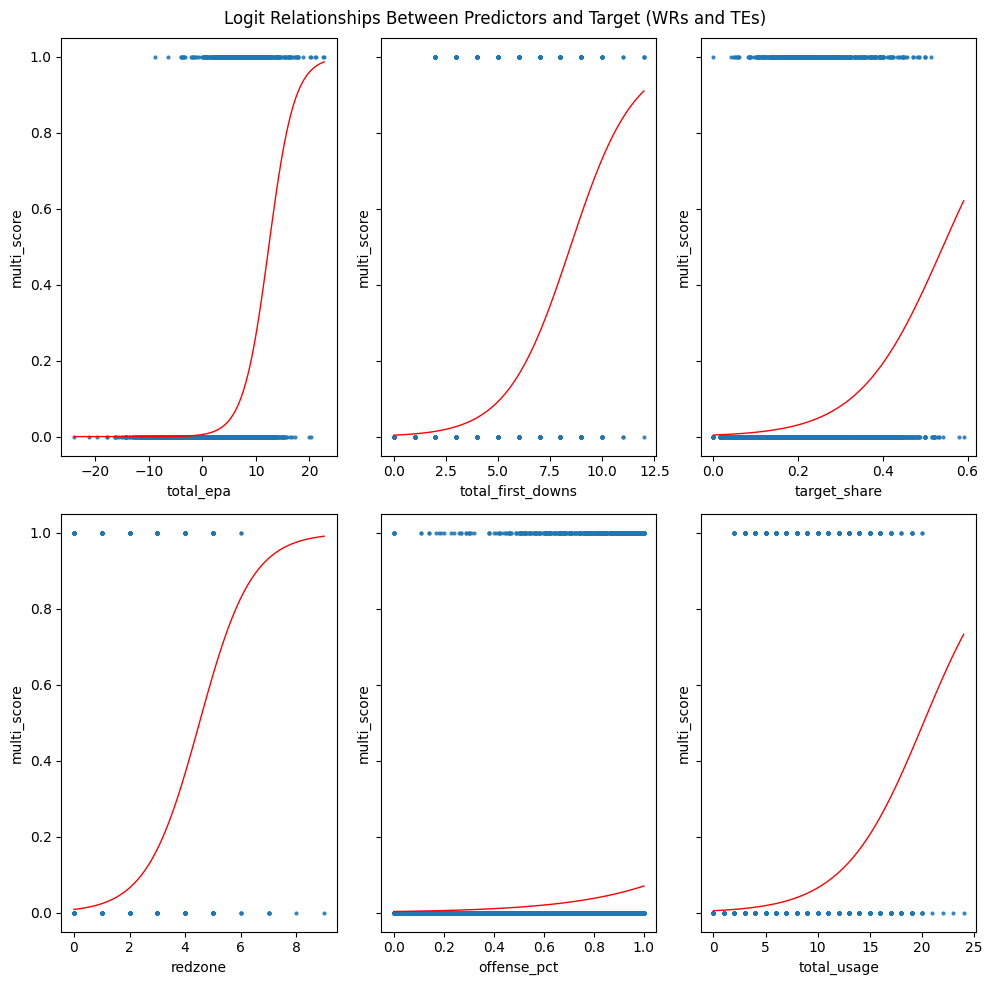

In [40]:
# With try columns, WRs and TEs ONLY!!!!!

# y = weekly1_non_rb[["scored"]]
y = weekly1_non_rb[["multi_score"]]

ncols = int(np.ceil(np.sqrt(len(try_columns))))
nrows = int(np.ceil(len(try_columns) / ncols))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharey=True)
fig.suptitle("Logit Relationships Between Predictors and Target (WRs and TEs)")

# Flatten the axes if nrows > 1
ax = ax.flatten()

for i, (col, ax_) in enumerate(zip(model_data_non_rb.columns, ax)):
    scatter_style = dict(s=4)
    line_style = dict(color="red", linestyle="-", linewidth=1)

    sns.regplot(x=model_data_non_rb[col], y=y, ax=ax_, logistic=True, ci=None, scatter_kws=scatter_style, line_kws=line_style)
    # ax_.set_title(col)

# Remove extra subplots
for i in range(len(model_data_non_rb.columns), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

In [41]:
# Looks like the threshold for scoring is 5 for RBs and 3 for WRs
# Multiscoring is 9 for RBs and 6 for WRs
# In terms of scoring, we love EPA and redzone targets/carries
# I should maybe look at how many redzone attempts each defense allowed per week

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

model = LogisticRegression()

y = weekly1[["scored"]].values
X = model_data.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=17)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [54]:
def calc_specificity(conf_matrix: np.array):
    specificity = conf_matrix[1, 0] / np.sum(conf_matrix[:, 0])
    return specificity

def calc_sensitivity(conf_matrix: np.array):
    sensitivity = conf_matrix[1, 1] / np.sum(conf_matrix[:, 1])
    return sensitivity

def calc_precision(conf_matrix: np.array):
    precision = conf_matrix[1, 1] / np.sum(conf_matrix[1, :])
    return precision

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

conf = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sensitivity = calc_sensitivity(conf)
specificity = calc_specificity(conf)
precision = calc_precision(conf)
auc_score = roc_auc_score(y_test, y_pred)

print(f"Accuracy:    {accuracy}")
print(f"Sensitivity: {sensitivity:}")
print(f"Specificity: {specificity}")
print(f"Precision:   {precision}")
print(f"AUC Score:   {auc_score}")

Accuracy:    0.8362410144576367
Sensitivity: 0.7143265656276808
Specificity: 0.14371032212555843
Precision:   0.44976593446164925
AUC Score:   0.6988781775598542


In [ ]:
# I want to better understand what the ROC AUC curve is